<a href="https://colab.research.google.com/github/mikiiiiiiiiiiiiiiiiiiii/Progetto_esame_reinforcement_learning/blob/main/Reinforcement_learing_for_stock_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **Deep Reinforcement Learning for Stock Trading : Multiple Stock Trading**

* [1. Introduzione: cos'è il Reinforcement learning](#0)
    * [1.1. Metodi value-based vs policy-based](#0.1)    
    * [1.2. Markov Decision Process](#0.2)
    * [1.3. Obiettivo e definizione del problema](#0.3)
* [2. Setup](#1)
    * [3.1 Installare e caricare pacchetti](#1.1)
    * [3.1 Download dati](#1.2)
* [4. Preprocess dei dati](#2)        
    * [4.1. Aggiungiamo degli indicatori tecnici](#2.1)
    * [4.2. Feature Engineering](#2.2)
    * [4.1. Split dei dati in Training & Trade](#3.1)
* [5. Creazione dell'environment](#3)  
    * [5.2. User-defined Environment](#3.2)   
    * [5.3. Initialize Environment](#3.3)    
* [6. Actor-Critic ](#4)  
* [7. Proximal Policy Optimization](#5)
* [7. Backtest](#6)  
    * [7.1. Risultati dell'A2C](#6.1)
    * [7.2. Risultati del PPO](#6.2)      
    * [7.3. Comparazione rispetto allo Stock Market Index](#6.4)       

# **Introduzione: cos'è il Reinforcement learning.**
Il `Reinforcement learning` è una branca dell'intelligenza artificiale che si occupa della risoluzione di problemi in cui un agente intelligente deve prendere la migliore decisione possibile (ossia quella che gli porta più guadagno) sulla base di dati oggettivi che non dipendono dall'agente stesso (l'ambiente).\
**Key concepts**:


*   ***Agent***: colui che decide e compie le azioni 
*   ***Environment***: ambiente con il quale l'agente interagisce (caratteristica principale dell'ambiente è la randomicità con cui lo stesso "trasporta" l'agente da uno stato all'altro)
*   ***Policy*** : politica con cui l'agente sceglie le azioni da compiere
*   ***Reward*** : ricompense che l'agente riceve interagendo con l'ambiente dopo che ha compiuto una determinata azione e si ritrova nel nuovo stato \
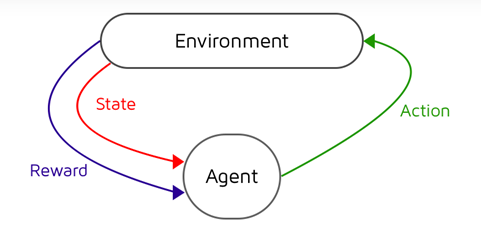

## **Metodi value-based vs metodi policy-based**
1. Nei metodi `value-based` ad ogni stato corrisponde un valore, l'agente ha l'obiettivo di prendere l'azione che lo porterà nello stato con più valore. \
Gli algoritmi value-based si basano tutti sull'`equazione di Bellman`: $v_π(s)=\sum_a π(a|s) \sum_{s',r} p(s',r|s,a) +[r+\gamma v_π(s')]$ \
per tutte le $s$ appartenenti allo spazio degli stati. \
Procederanno quindi ad imparare i valori relativi agli stati visitati attraverso un processo iterativo costituito da: **la valutazione** della policy in cui l'agente fa esperienza dell'ambiente e riceve le relative ricompense e **l'update** della policy, step nel quale l'agente modifica la politica con cui sceglie l'azione in modo tale da scegliere le azioni che lo portano negli stati con più alto valore. \
*Vantaggio*: efficienti se si utilizzano le reti neurali come approssimatori degli stati e spesso converogono ad una policy ottimale. \
*Svantaggio*: difficile applicazione su problemi concreti a causa della loro alta complessità. \
2. Nei metodi`policy-based` l'agente attribuisce una distribuzione di probabilità alle azioni disponibili, il suo obiettivo sarà quello di trovare la distribuzione di probabilità che massimizza il guadagno. \
La distribuzione delle probabilità viene **parametrizzata**($\theta$) in maniera da consentire all'agente di ottimizzare attraverso la discesa del gradiente una funzione di loss, vediamo che con i metodi policy-based l'agente non "passa" attraverso una funzione di valore degli stati ma si concentra direttamente sulla scelta dell'azione. \
*Vantaggio*: possono descrivere un'ampia gamma di problemi sopratutto quelli in cui la distribuzione delle azioni è continua. \
*Svantaggio*: purtoppo sono metodi in cui la convergenza verso una policy ottimale può essere difficile a causa dell'alta varianza degli update della stessa che quindi causa instabilità e lentezza durante l'allenamento. \
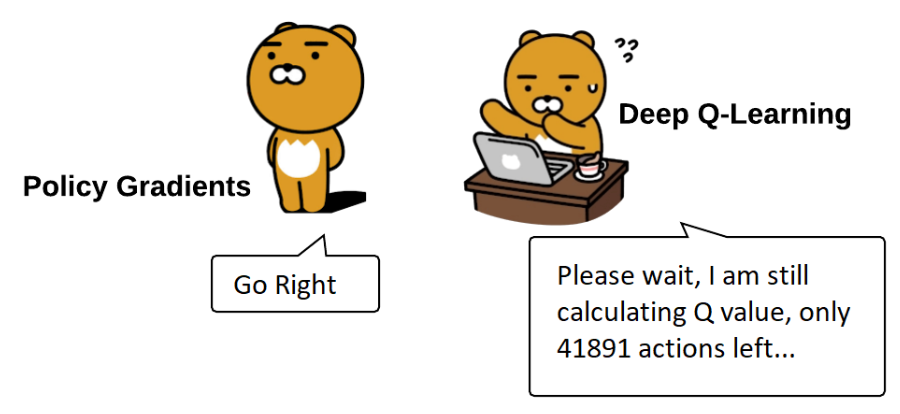

##**Markov Decision Process** 
Gli MDPs sono dei `frameworks` per rappresentare i problemi di decisione che coinvolgono una parte di randomness e una deterministica data dalla scelta dell'azione da compiere. \
Esistono diversi tipi di MDP, tutti però hanno in comune:

  * $S$: stato degli ***spazi***,
  * $A$: stato delle ***azioni***,
  * $P_a(s,s')=Pr(s_{t+1}=s'|s_t=s , a_t=a)$: matrice delle probablità di transizione caratteristica dell'ambiente con l'ambiente risponde quando l'agente si trova nello stato $s$ e sceglie l'azione $a$. 
\
Esempio di Markov Decision Process:
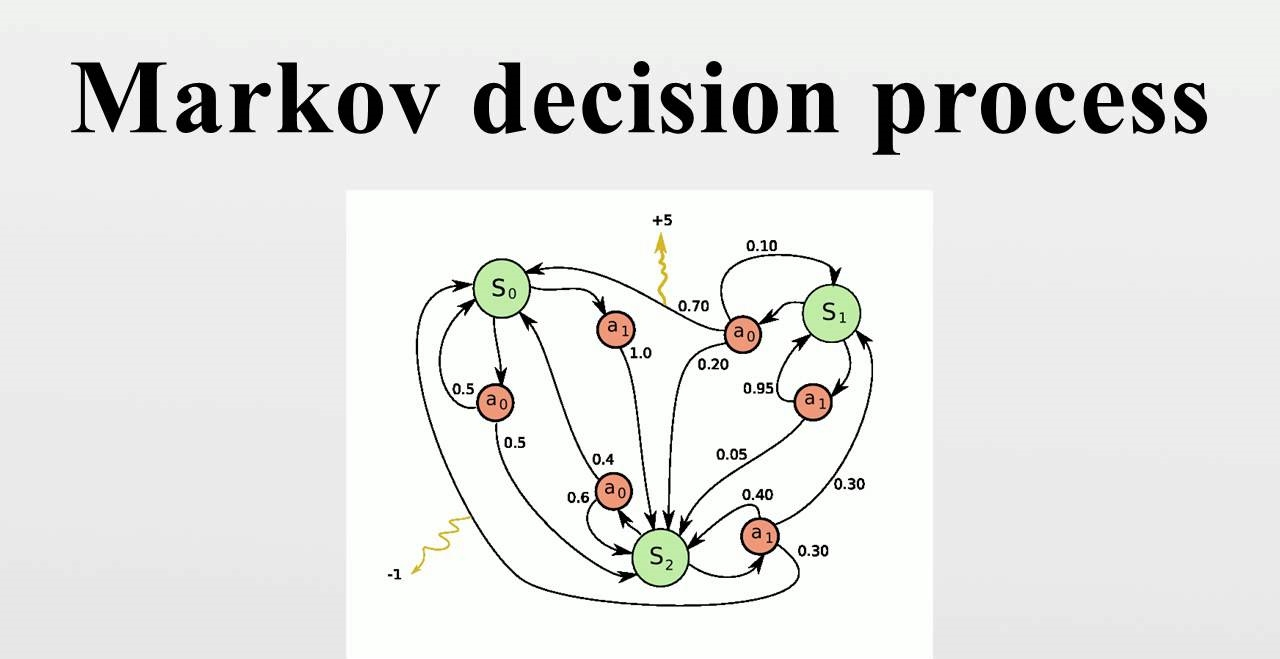

# **Obiettivo e definizione del problema**

In questo notebook verraano presentati e utilizzati due algoritmi: 
* `A2C` -> ibrido, value-based e policy-based
* `PPO` -> policy-based

Dovranno risolvere il complicato task di vendere, comprare o holdare un asset finanziario al fine di massimizzare il guadagno (molto banalmente espresso in termini monetari). \
L'obiettivo finale è quello di generare `alpha`, termine tecnico per indicare quella situazione in cui i rendimenti della strategia trovata dall'algoritmo sono maggiori di quelli che si ottengono detenendo passivamente tutto il "mercato" in portafoglio. \
 Come abbiamo visto, generalmente, i problemi che si vogliono risolvere con il reinforcement learing vengono rappresentati con dei `Markov Decision Process`. \
Partiamo con una versione semplificata per poi arrivare alla rappresentazione di nostro interesse:

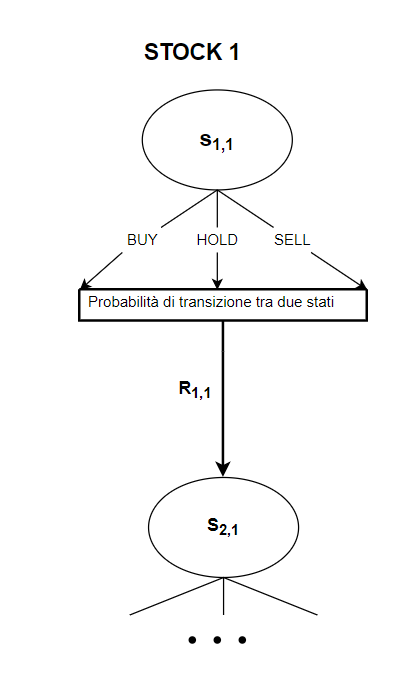

Nel nostro MDP l'ambiente è costituito da una sola stock e `gli stati corrispondono ai prezzi dell'asset finanziario` preso in considerazione. Le azioni che possiamo compiere sono sempre tre: comprare, vendere oppure tenere tutte le azioni che abbiamo, se non ne abbiamo nessuna compreremo o venderemo un tot numero di azioni. \
**Per generare alpha in maniera costante il nostro algoritmo dovrebbe imparare la probabilità di transizione tra gli stati**. \
**IMPORTANTE:** Le nostre azioni non potranno influenzare il mercato; come vediamo il mercato stabilirà il prezzo al tempo 2 solo in base alla probabilità di transizione tra uno stato e l'altro; è importante notare che le probabilità di transizione possono cambiare nel tempo, l'assunzione più ragionevole è quella secondo la quale le probabilità cambiano in maniera rilevante a lungo andare ma non a breve termine(?). \
Se consideriamo l'ambiente composto dal basket di stocks presenti nell'indice `DOW 30` la situazione diventa più complessa, potremmo pensare di rappresentarla in questo modo:

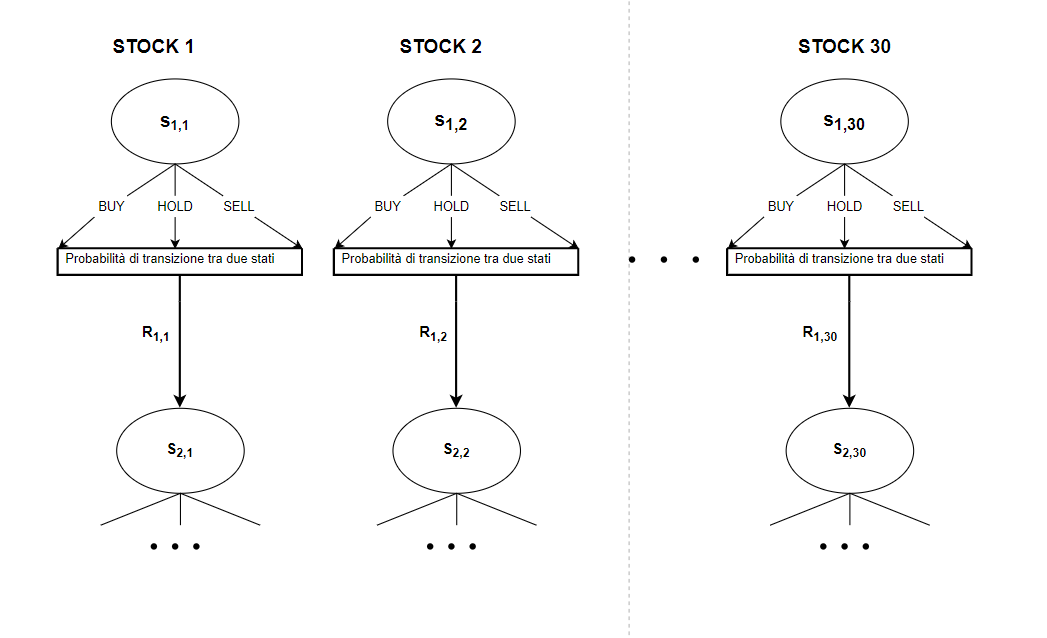

Dal MDP non sembra ci sia interazione tra i vari stati nel tempo; in realtà quello che succede è che gli asset sono `molto correlati tra loro` e la nostra strategia dovrà tenerne conto!

**NB**: nel problema preso in esame stiamo semplificando le cose, in realtà le possibili azioni che possiamo compiere sono molte di più: possiamo infatti vendere o comprare un *numero diverso* dal totale che abbiamo in portafoglio e questo per ogni azione che teniamo in considerazione per l'allenamento. 

#**Setup**
###**Installare e caricare i pacchetti**

In [1]:
 ## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-d71n_lom
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-d71n_lom
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-qfflamyr/pyfolio_b2277acf42c24d2985b15f0d0e52c1fa
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-qfflamyr/pyfolio_b2277acf42c24d2985b15f0d0e52c1fa
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-qfflamyr/elegantrl_ce1f8ceeb3a24c3e83e1a61a2f300f2f
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-qfflamyr/elegantrl_ce1f8ceeb3a24c3e83e1a61a2f300f2f
     |████████████████████████████████| 234 kB 24.8 MB/s 
     |████████████████████████████████| 177 kB 38.9 MB/s 
     |█████████████████████

In [2]:
!pip install quantstats
!pip install stable-baselines3[extra]
!pip install pyfolio
!pip install stockstats 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 248 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from finrl import config
from finrl import config_tickers
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import quantstats as qs
import stable_baselines3 
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent, TensorboardCallback
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


###**Download dei dati**

In [5]:
# from config.py TRAIN_START_DATE is a string
config.TRAIN_START_DATE
config.TRAIN_END_DATE
df = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2021-10-31',
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [6]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [7]:
df.shape

(94331, 8)

In [8]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.771173,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,44.867592,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.535339,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,32.164715,7117200,CAT,4


# **Preprocess dei dati**
### **Aggiungiamo degli indicatori tecnici**

In [9]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3229, 8)
Successfully added vix
Successfully added turbulence index


In [10]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.771173,746015200.0,4.0,0.0,2.995051,2.664251,100.0,66.666667,100.0,2.771173,2.771173,39.189999,0.0
1,2009-01-02,AMGN,58.590000,59.080002,57.750000,44.867592,6547900.0,4.0,0.0,2.995051,2.664251,100.0,66.666667,100.0,44.867592,44.867592,39.189999,0.0
2,2009-01-02,AXP,18.570000,19.520000,18.400000,15.535339,10955700.0,4.0,0.0,2.995051,2.664251,100.0,66.666667,100.0,15.535339,15.535339,39.189999,0.0
3,2009-01-02,BA,42.799999,45.560001,42.779999,33.941101,7010200.0,4.0,0.0,2.995051,2.664251,100.0,66.666667,100.0,33.941101,33.941101,39.189999,0.0
4,2009-01-02,CAT,44.910000,46.980000,44.709999,32.164715,7117200.0,4.0,0.0,2.995051,2.664251,100.0,66.666667,100.0,32.164715,32.164715,39.189999,0.0
5,2009-01-02,CRM,8.025000,8.550000,7.912500,8.505000,4069200.0,4.0,0.0,2.995051,2.664251,100.0,66.666667,100.0,8.505000,8.505000,39.189999,0.0
6,2009-01-02,CSCO,16.410000,17.000000,16.250000,12.265081,40980600.0,4.0,0.0,2.995051,2.664251,100.0,66.666667,100.0,12.265081,12.265081,39.189999,0.0
7,2009-01-02,CVX,74.230003,77.300003,73.580002,44.807625,13695900.0,4.0,0.0,2.995051,2.664251,100.0,66.666667,100.0,44.807625,44.807625,39.189999,0.0
8,2009-01-02,DIS,22.760000,24.030001,22.500000,20.597500,9796600.0,4.0,0.0,2.995051,2.664251,100.0,66.666667,100.0,20.597500,20.597500,39.189999,0.0
9,2009-01-02,GS,84.019997,87.620003,82.190002,71.168274,14088500.0,4.0,0.0,2.995051,2.664251,100.0,66.666667,100.0,71.168274,71.168274,39.189999,0.0


### **Data Split**

In [11]:
train = data_split(processed_full, '2009-01-01','2020-07-01')
trade = data_split(processed_full, '2020-07-01','2021-10-31')
print(len(train))
print(len(trade))

83897
9744


In [12]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 291


In [13]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

###**Creazione dell'Environment**


In [14]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [15]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

# **Advantage Actor-Critic**
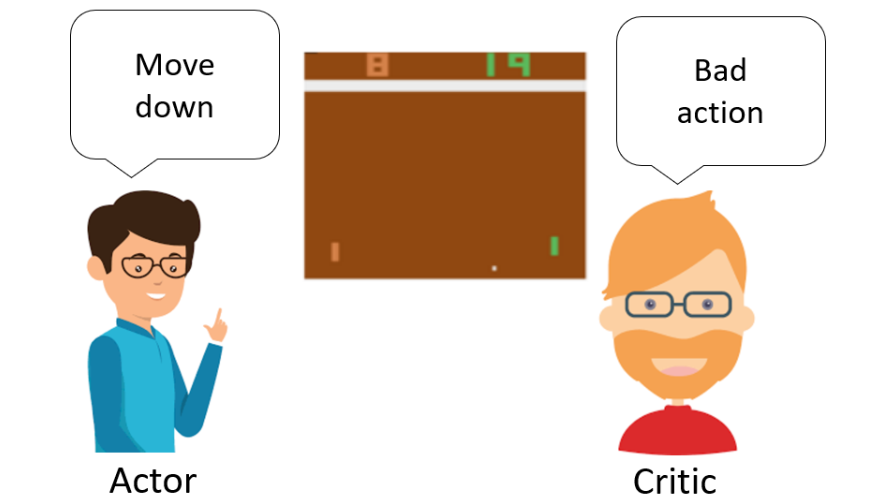 \
L'algoritmo A2C è un ibrido dei due approcci (value e policy based).
Come possiamo intuire dalla sua denominazione ha due componenti:
* `Attore`: che sceglie le sue azioni secondo un algoritmo policy-based (spesso usato REINFORCE --> monte-carlo policy-gradient)
* `Critico`: composto da un Q-learning che "giudica" le azioni prese dall'attore e quindi restituendo un feedback su come dovrà sceglierle successivamente

Per una spiegazione di come funziona il `DQN` consulare l'appendice finale del notebook.

Breve spiegazione dell'algoritmo `REINFORCE`: \
Cronologicamente uno tra i primi del tipo policy-based; 
prende in considerazione il guadagno di tutto il percorso  di esperienza dell'ambiente (Monte-Carlo) e successivamente aggiorna i pesi della distribuzione delle azioni massimizzando il guadagno; presenta i problemi che abbiamo sottolineato precedentemente per questo tipo di algoritmi, a tali problemi cercano di rimediare i moderni algoritmi dello stato dell'arte come il PPO che vedremo successivamente. 

$$∇J(θ)=E_T \left[\sum_{t=0}^{T-1} ∇_θ\log\pi_θ(a_t,s_t) \cdot G_t\right]$$
un modo per ridurre la varianza e aumentare la stabilità è introdurre una baseline funcion $b(s)$ da sottrarre ai ritorni cumulativi $G_t$
$$∇J(θ)=E_T \left[\sum_{t=0}^{T-1} ∇_θ\log\pi_θ(a_t,s_t)\cdot (G_t-b(t))\right]$$
**In che modo avviene il procedimento di azione->critica?** \
Tale procedimento è reso possibile tramite una modifica dell'appena visto REINFORCE, modifica che esporremo direttamente mostrando l'intuizione matematica su cui si basa, decomponiamo il valore atteso in questo modo:
$$∇J(θ)=E_T \left[\sum_{t=0}^{T-1} ∇_θ\log\pi_θ(a_t,s_t)\right] \cdot E_\tau[G_t]$$ dove $\tau$ è il percorso che ha appena fatto l'attore. \
Notiamo che:
$$E_\tau[G_t]=Q(a_t,s_t)$$
così l'equazione di update diventa:
$$∇J(θ)=E_T \left[\sum_{t=0}^{T-1} ∇_θ\log\pi_θ(a_t,s_t)\right] \cdot Q(a_t,s_t)$$
il Q-value verrà approssimato tramite una rete neurale (vedi Q-network), inoltre prendiamo come baseline function $V(s_t)$ in modo da ottenere l'**advantage value**: $A(a_t,s_t)=Q(a_t,s_t)-V(s_t)$


**Pseudo-code** \
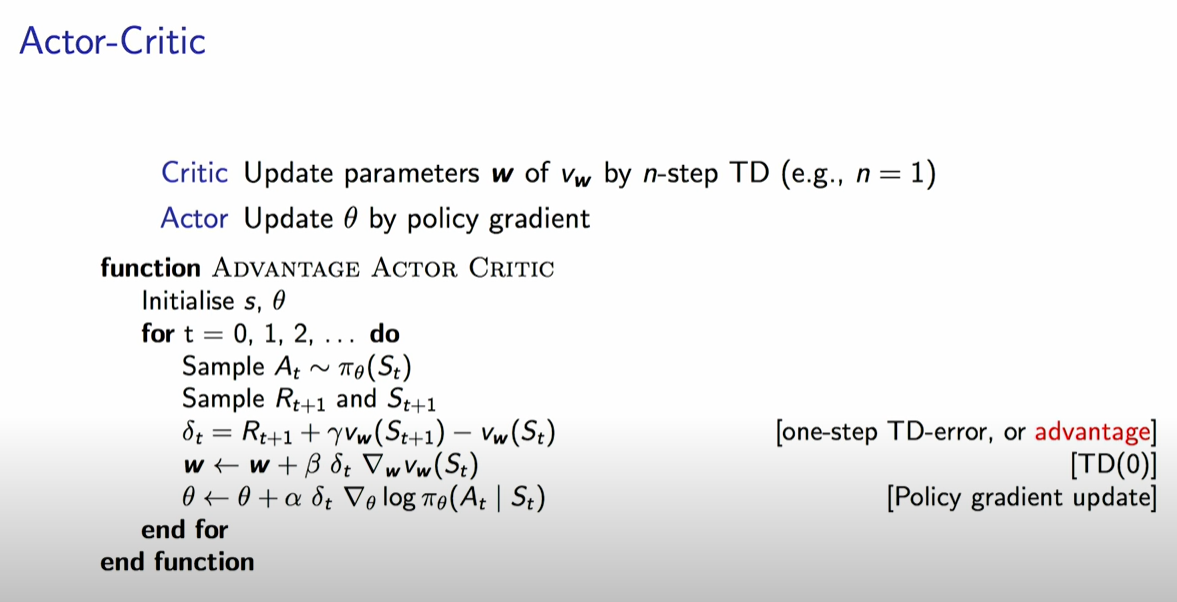

\

In [16]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


In [17]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='./a2c',
                             total_timesteps=50_000)

--------------------------------------
| time/                 |            |
|    fps                | 110        |
|    iterations         | 100        |
|    time_elapsed       | 4          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.2      |
|    explained_variance | -0.332     |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | 1.24       |
|    reward             | 0.23681779 |
|    std                | 1          |
|    value_loss         | 0.0627     |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 110        |
|    iterations         | 200        |
|    time_elapsed       | 9          |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -41.2      |
|    explained_variance | -1.96      |
|    learning_rate      |

# **Proximal Policy Optimization**
Il PPO è uno degli algoritmi policy-based più usati e più efficienti nell'ambito del reinforcement learning:
* è **on-policiy**
* è **parallelizzabile**
* può essere usato sia per policy **stocastiche** che **deterministiche** \

E' l'evoluzione del TRPO, osservando infatti le rispettive funzioni di massimizzazione notiamo la forte somiglianza. 
TRPO: \
$$L^{CPI}(θ)= \mathbb{E}_t\left[\frac{π_θ(a_t|s_t)}{π_{θ_{old}}(a_t|s_t)}\hat{A_t} \right]$$
dove per CPI intendiamo una policy iteration conservativa, senza nessun vincolo la massimizzazione di tale funzione porterebbe a degli update eccessivi della policy per questo motivo dobbiamo penalizzare un update della polcy che porti il rapporto: \
$$r_t(\theta)=\frac{π_θ(a_t|s_t)}{π_{θ_{old}}(a_t|s_t)}$$
lontano da 1, arriviamo quindi alla funzione da massimizzare del PPO:
$$J^{CLIP}(θ)=\mathbb{E}_t\left[\min(r_t(\theta)\hat{A_t},clip(r_t(\theta),1-ϵ,1+ϵ)\hat{A_t}\right]$$

PS: il termine $\hat{A_t}$ viene chiamato funzione vantaggio e misura quanto buona è l'azione intrapresa attraverso questa differenza : $Q(s,a)-V(s)$

**Pseudo-code** \

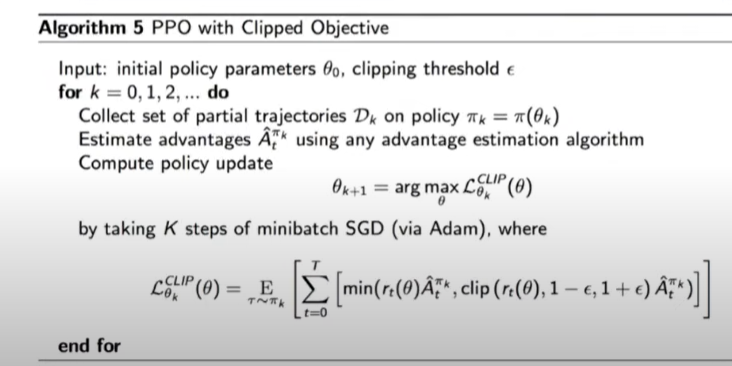

In [18]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device


In [19]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50_000)

----------------------------------
| time/              |           |
|    fps             | 116       |
|    iterations      | 1         |
|    time_elapsed    | 17        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.2940565 |
----------------------------------
day: 2892, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 3360269.38
total_reward: 2360269.38
total_cost: 351823.16
total_trades: 81155
Sharpe: 0.740
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 2           |
|    time_elapsed         | 35          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014734106 |
|    clip_fraction        | 0.237       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.00571    |
|    learning_rate 

# **Backtest**

# **Risultati dell'A2C**

In [20]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym)

hit end!


In [21]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_a2c)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.276613
Cumulative returns     0.384881
Annual volatility      0.125779
Sharpe ratio           2.011118
Calmar ratio           3.307095
Stability              0.948576
Max drawdown          -0.083642
Omega ratio            1.397160
Sortino ratio          2.977354
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.093623
Daily value at risk   -0.014843
dtype: float64


In [22]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value_a2c.loc[0,'date'],
        end = df_account_value_a2c.loc[len(df_account_value_a2c)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)
Annual return          0.273520
Cumulative returns     0.379084
Annual volatility      0.139248
Sharpe ratio           1.811893
Calmar ratio           3.062662
Stability              0.918651
Max drawdown          -0.089308
Omega ratio            1.351851
Sortino ratio          2.684720
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.051856
Daily value at risk   -0.016542
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)


Start date,2020-07-01
End date,2021-10-28
Total months,16
,Backtest
Annual return,27.661%
Cumulative returns,38.488%
Annual volatility,12.578%
Sharpe ratio,2.01
Calmar ratio,3.31
Stability,0.95
Max drawdown,-8.364%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.36,2020-09-02,2020-09-23,2020-11-09,49
1,4.99,2021-08-20,2021-09-30,2021-10-19,43
2,4.41,2021-02-17,2021-03-04,2021-03-11,17
3,3.73,2021-05-10,2021-06-18,2021-07-02,40
4,2.83,2020-11-16,2020-12-14,2021-01-07,39


Stress Events,mean,min,max
New Normal,0.10%,-2.86%,2.15%


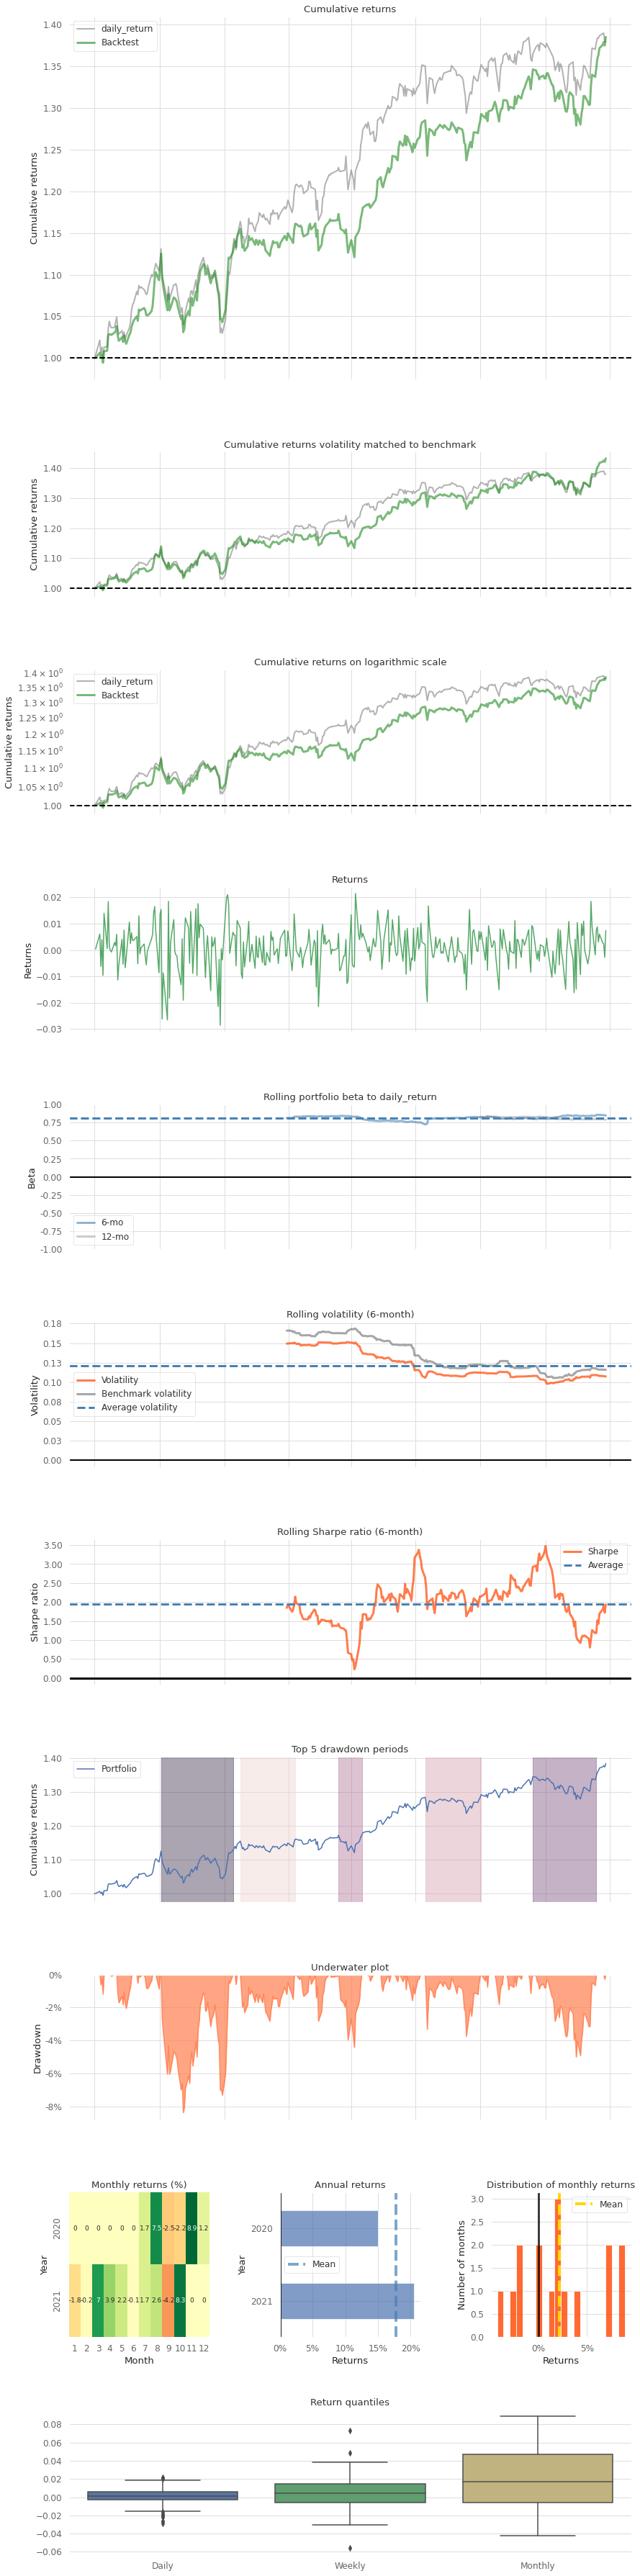

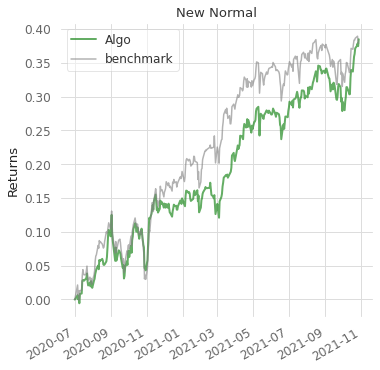

In [23]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value_a2c, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value_a2c.loc[0,'date'],
             baseline_end = df_account_value_a2c.loc[len(df_account_value_a2c)-1,'date'])

# **Risulatati del PPO**

In [24]:
df_account_value_ppo, df_actions1_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)

hit end!


In [25]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_ppo)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.381100
Cumulative returns     0.538037
Annual volatility      0.142071
Sharpe ratio           2.351711
Calmar ratio           4.407957
Stability              0.938193
Max drawdown          -0.086457
Omega ratio            1.487586
Sortino ratio          3.673748
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.116069
Daily value at risk   -0.016573
dtype: float64


In [26]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value_ppo.loc[0,'date'],
        end = df_account_value_ppo.loc[len(df_account_value_ppo)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)
Annual return          0.273520
Cumulative returns     0.379084
Annual volatility      0.139248
Sharpe ratio           1.811893
Calmar ratio           3.062662
Stability              0.918651
Max drawdown          -0.089308
Omega ratio            1.351851
Sortino ratio          2.684720
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.051856
Daily value at risk   -0.016542
dtype: float64


In [27]:
df_account_value_ppo.loc[0,'date']

'2020-07-01'

In [28]:
df_account_value_ppo.loc[len(df_account_value_ppo)-1,'date']

'2021-10-28'

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)


Start date,2020-07-01
End date,2021-10-28
Total months,16
,Backtest
Annual return,38.11%
Cumulative returns,53.804%
Annual volatility,14.207%
Sharpe ratio,2.35
Calmar ratio,4.41
Stability,0.94
Max drawdown,-8.646%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.65,2020-10-12,2020-10-28,2020-11-09,21
1,6.62,2021-09-02,2021-09-30,2021-10-28,41
2,6.37,2020-09-02,2020-09-23,2020-10-09,28
3,4.49,2021-06-04,2021-06-18,2021-07-02,21
4,3.84,2021-05-07,2021-05-12,2021-06-04,21


Stress Events,mean,min,max
New Normal,0.13%,-3.74%,3.51%


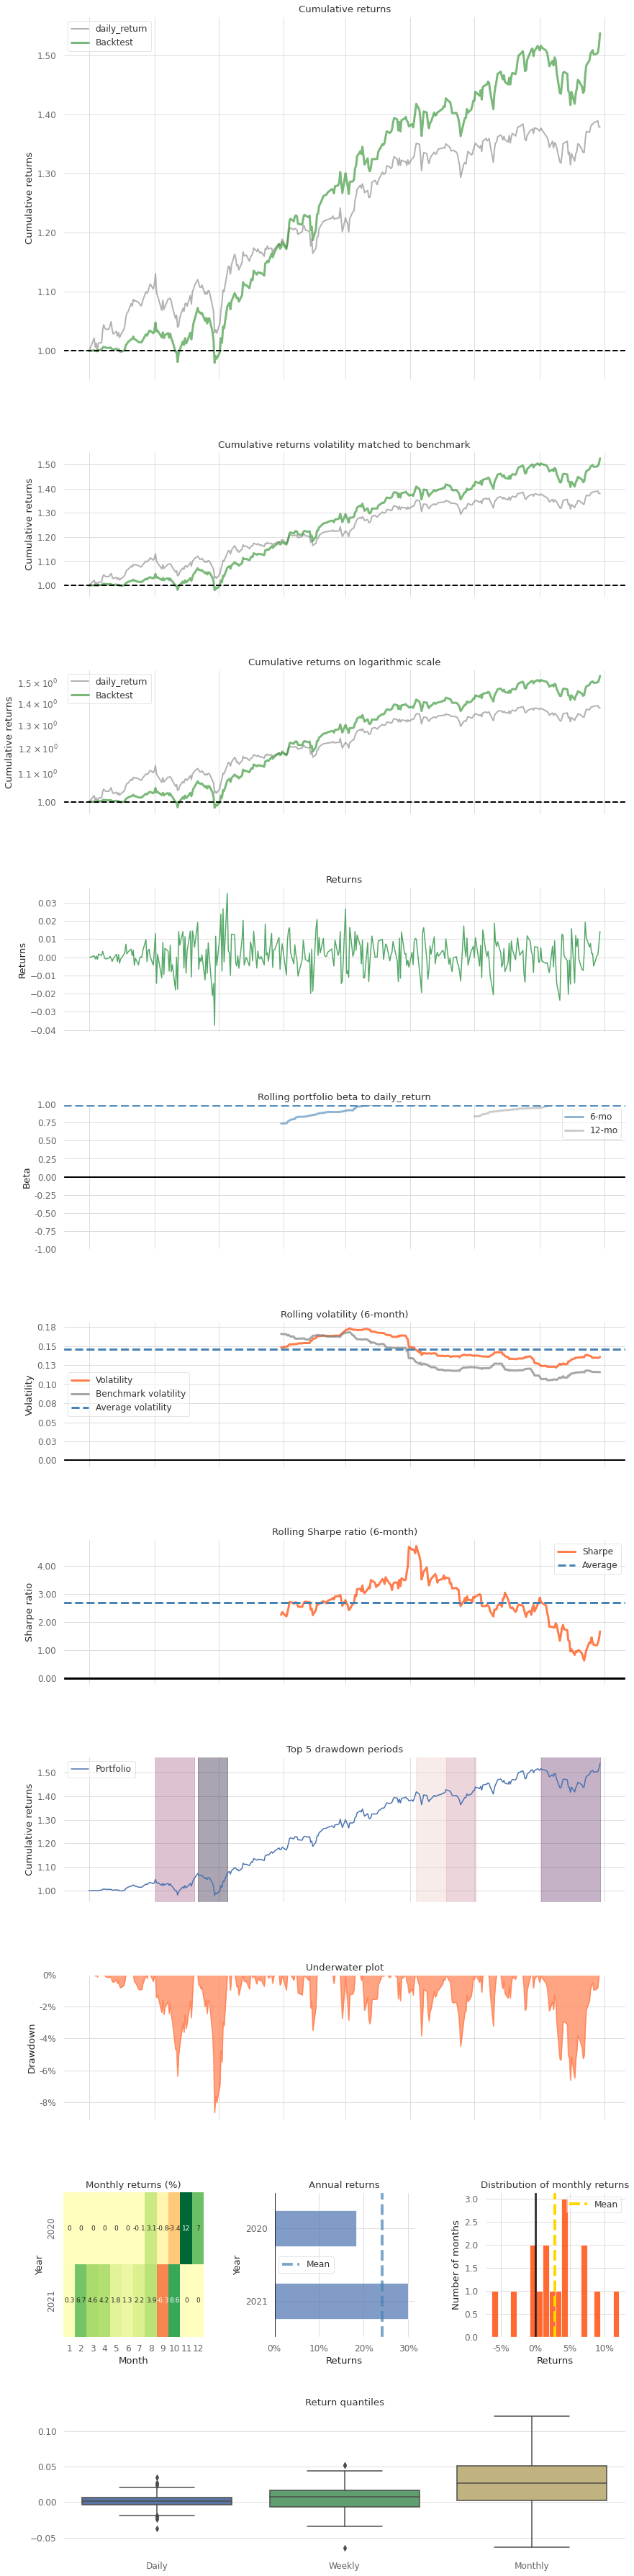

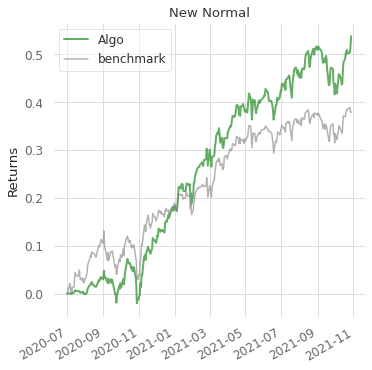

In [29]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value_ppo, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value_ppo.loc[0,'date'],
             baseline_end = df_account_value_ppo.loc[len(df_account_value_ppo)-1,'date'])

# **Conclusioni**
Il **reinforcement** può non sembrare il miglior tool per il `forecasting di serie temporali finanziarie` a causa della sua **"fame"** di big data e dall'altra parte l'impossibilità (per ora) di creare dati sintetici che rappresentino fedelmente una serie temporale come quella di un asset finanziario; dobbiamo perciò stare molto attenti a prendere in considerazione solo la performance delle strategie che otteniamo ed eseguire analisi più approfondite prima di poterle utilizzare. \
Come abbiamo visto però gli algoritmi che oggi sono lo stato dell'arte possono funzionare bene, sopratutto se utilizzati su un ambiente che contiene un basket di stocks, il mio parere infatti è che una performance più che positiva può essere raggiunta da questi algoritmi nel momento in cui vengono costrutiti per imparare correlazioni (magari non-lineari) tra le varie azioni.


# **Appendice**
## **Deep Q-Network**
L'algoritmo `Q-network` fu sviluppato nel 2015 da DeepMind e rientra nella categoria value-based. Per capirlo dobbiamo partire dal `Q-learning`, algoritmo molto famoso, rivelatosi efficace ed efficiente in un gran numero di applicazioni. \
I concetti cardine in questo caso sono due: la ***Q-function*** e l'***equazione di Bellman***. \
La prima indica il valore che l'agente attribuisce ad ogni coppia stato-azione e la si indica in questo modo $Q_π(s,a)$. \
La regola di update dei valori delle coppie $(s,a)$ deriva dall'equazione di Bellman (vista prima) e dal metodo `Temporal Difference` grazie al quale possiamo aggiornare tali valori dopo ogni passo (al contrario dei metodi `Monte-Carlo` che per aggiornare i valori delle coppie stato-azione utilizzano la somma scontata delle ricompense ricevute durante tutto il percorso dallo stato iniziale fino a quello finale). \
 è la seguente:
$$Q_π'(s,a)=Q_π(s,a)+α[R(s,a)+\gamma \cdot \max Q_π'(s',a')-Q_π(s,a)]$$



L'immagine seguente mostra lo pseudo codice per il Q-learning e quindi anche la regola di update che si trova alla sua base: Temporal-Difference.

 **Psuedo-code** \

 
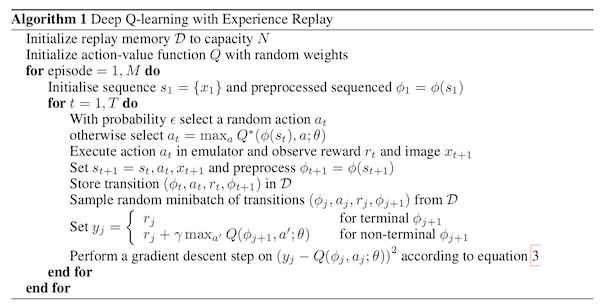

###**Differenza tra Q-network e Q-learning:**
E' evidente il limite del Q-learning, può essere applicato solo con problemi giocattolo, in cui è possibile memorizzare su una macchina tutti i valori delle coppie stato-azione; quando abbiamo a che fare con problemi più complessi come il nostro bisogna `approssimare` i Q-values, usando una rete neurale come approssimatore è possibile arrivare ad un buon risultato. \
Pertanto utilizzeremo una `rete neurale` con parametri $θ$, per stimare i valori di $Q$, cioè $Q(s,a,θ) \approx Q^*(s,a)$. Questo può fatto minimizzando la seguente perdita ad ogni passo $i$:
 $$L_i(\theta_i)=\mathbb{E}_{s,a,r,s'\sim \rho(\cdot)}\left[(y_i-Q(s,a,θ_i))^2\right]$$
 dove: $y_i=r+\gamma \cdot \max_{a'}Q'(s',a';\theta_{i-1})$

**Q-network**: \
 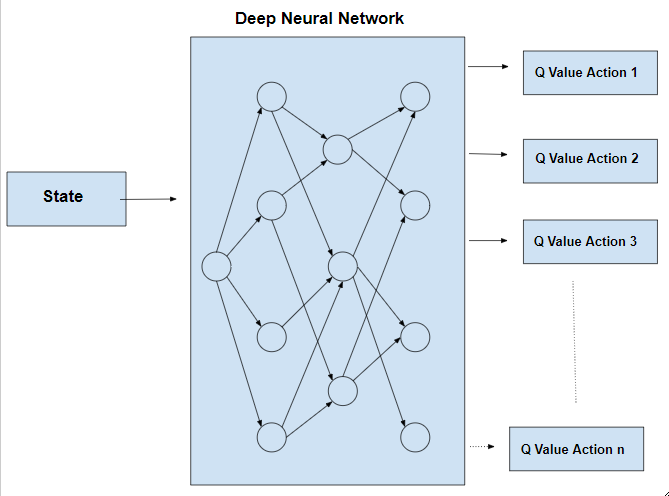

**Q-Learning:** \
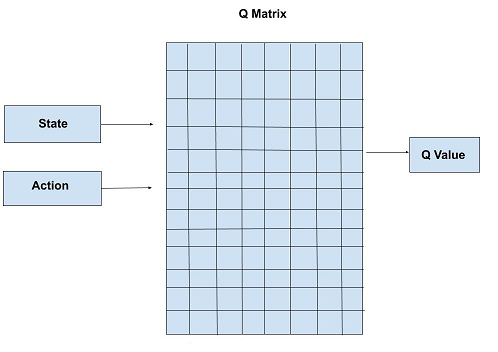

In [ ]:
prediction = DRLAgent.DRL_validation('a2c')